## Linear SVM

In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
# Iris dataset.
iris = datasets.load_iris()     # Load Iris dataset.

X = iris.data                   # The shape of X is (150, 4), which means
                                # there are 150 data points, each data point
                                # has 4 features.

# Here for convenience, we divide the 3 kinds of flowers into 2 groups:
#     Y = 0 (or False):  Setosa (original value 0) / Versicolor (original value 1)
#     Y = 1 (or True):   Virginica (original value 2)

# Thus we use (iris.target > 1.5) to divide the targets into 2 groups.
# This line of code will assign:
#    Y[i] = True  (which is equivalent to 1) if iris.target[k]  > 1.5 (Virginica)
#    Y[i] = False (which is equivalent to 0) if iris.target[k] <= 1.5 (Setosa / Versicolor)

Y = (iris.target > 1.5).reshape(-1,1).astype(float) # The shape of Y is (150, 1), which means
                                # there are 150 data points, each data point
                                # has 1 target value.
Y[Y==0] = -1

X_and_Y = np.hstack((X, Y))     # Stack them together for shuffling.
np.random.seed(1)               # Set the random seed.
np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array

print(X.shape)
print(Y.shape)
print(X_and_Y[0])               # The result should be always: [ 5.8  4.   1.2  0.2  -1. ]

(150, 4)
(150, 1)
[ 5.8  4.   1.2  0.2 -1. ]


In [3]:
# Divide the data points into training set and test set.
X_shuffled = X_and_Y[:,:4]
Y_shuffled = X_and_Y[:,4]


X_train = X_shuffled[:100][:,[3,1]] # Shape: (100,2)
X_train = np.delete(X_train, 42, axis=0) # Remove a point for separability.
Y_train = Y_shuffled[:100]          # Shape: (100,)
Y_train = np.delete(Y_train, 42, axis=0) # Remove a point for separability.
X_test = X_shuffled[100:][:,[3,1]]  # Shape: (50,2)
Y_test = Y_shuffled[100:]           # Shape: (50,)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(99, 2)
(99,)
(50, 2)
(50,)


In [6]:
def vis(X, Y, W=None, b=None):
    indices_neg1 = (Y == -1).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1],
                c='blue', label='class -1')
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1],
                c='red', label='class 1')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

    if W is not None:
        # w0x0+w1x1+b=0 => x1=-w0x0/w1-b/w1
        w0 = W[0]
        w1 = W[1]
        temp = -w1*np.array([X[:,1].min(), X[:,1].max()])/w0-b/w0
        x0_min = max(temp.min(), X[:,0].min())
        x0_max = min(temp.max(), X[:,1].max())
        x0 = np.linspace(x0_min,x0_max,100)
        x1 = -w0*x0/w1-b/w1
        plt.plot(x0,x1,color='black')

    plt.show()

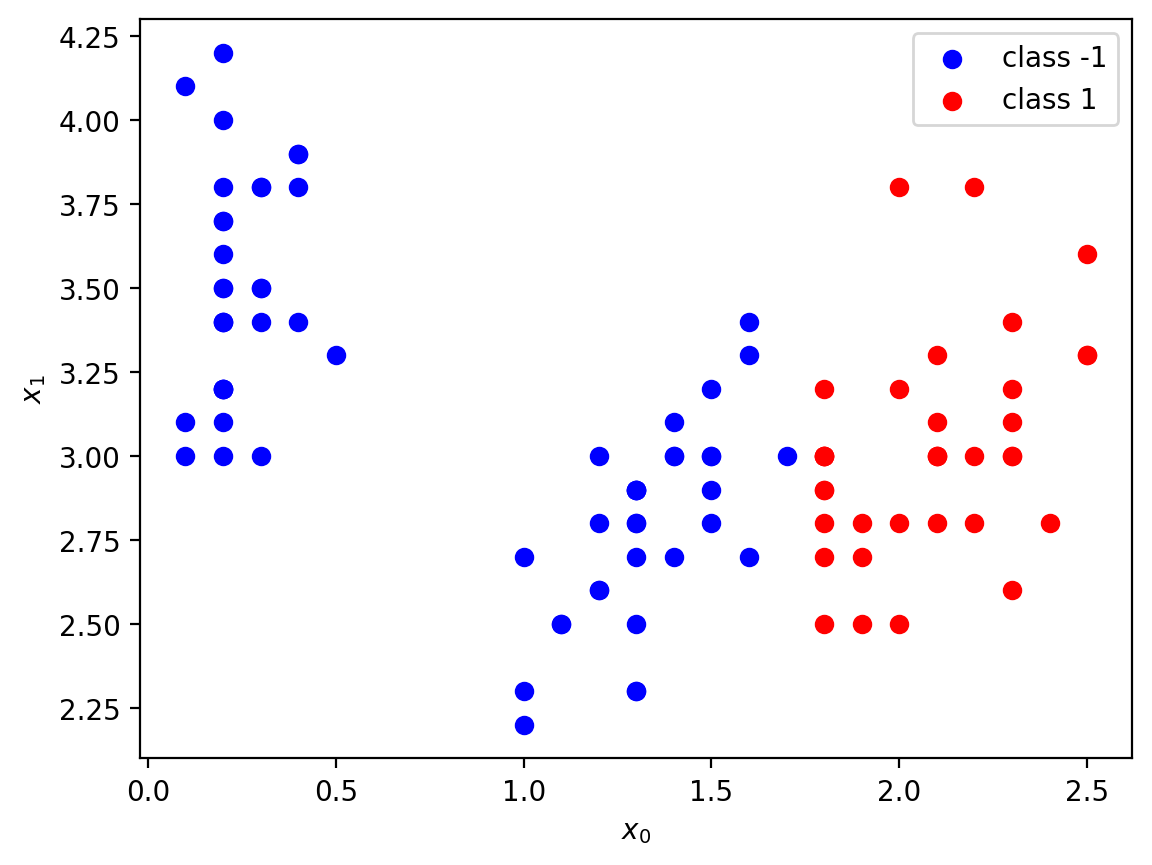

In [7]:
# Visualize training set.
vis(X_train, Y_train)

### Linear SVM Using Gradient Descent

In [8]:
# Judge function: 1(a != b). It supports scalar, vector and matrix.
def judge_1(a, b):
    return np.array(a != b).astype(np.float32)

# Judge function: 1(z > 0). It supports scalar, vector and matrix.
def judge_2(z):
    return np.array(z > 0).astype(np.float32)

# Rectifier function: (z)_+ = max(0, z). It supports scalar, vector and matrix.
def rectifier(z):
    return np.clip(z, a_min=0, a_max=None)

# Linear SVM classifier.
def f_linear_svm(x, W, b):
    # x should be a 2-dimensional vector,
    # W should be a 2-dimensional vector,
    # b should be a scalar.
    # you should return a scalar which is -1 or 1.
    z = np.dot(x, W) + b
    if z >= 0:
        return 1
    else:
        return -1

# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, W, b):
    e = 0
    n = len(X)
    for (xi, yi) in zip(X, Y):
        pred_val = f_linear_svm(xi, W, b)
        e = e + judge_1(yi, pred_val)
    e = e/n
    return e

In [9]:
# Gradient of L(W, b) with respect to W and b.
def grad_L_W_b(X, Y, W, b, C):
    X = np.asarray(X)
    Y = np.asarray(Y)
    W = np.asarray(W)
    
    a = 1 - Y * (X @ W + b)
    z = judge_2(a) * Y
    
    grad_W = W - C * (X.T @ z) # vec,(d,)
    grad_b = -C * np.sum(z) #scalar
    return grad_W, grad_b

In [10]:
grad_L_W_b(X_train, Y_train, [2, 3], 4, 2)

(array([102.4, 398.8]), 126.0)

In [11]:
# Loss L(W, b). #change all
def L_W_b(X, Y, W, b, C):
    X = np.asarray(X)
    Y = np.asarray(Y)
    W = np.asarray(W)
    
    # margin
    margin = 0.5 * (W.T @ W)

    # hinge
    a = 1 - Y * (X @ W + b)
    hinge_loss = C * np.sum(rectifier(a))
    
    loss_function = margin + hinge_loss
    return loss_function

In [12]:
L_W_b(X_train, Y_train, [2, 3], 4, 2)

2024.6999999999998

In [13]:
learning_rate = 0.0001
iterations    = 10000
losses = []

# Gradient descent algorithm for linear SVM classifier.
# Step 1. Initialize the parameters W, b.
W = np.zeros(2)
b = 0
C = 1000

for i in range(iterations):
    # Step 2. Compute the partial derivatives.
    grad_W, grad_b = grad_L_W_b(X_train, Y_train, W, b, C)
    # Step 3. Update the parameters.
    W = W - (grad_W * learning_rate) 
    b = b - (grad_b * learning_rate) 

    # Track the training losses.
    losses.append(L_W_b(X_train, Y_train, W, b, C))

In [14]:
losses[::1000]

[921399.0280500001,
 1599.6673753754894,
 776.986388399424,
 507.87186538938624,
 424.9399434656031,
 357.15571928063827,
 301.97702771080844,
 256.71571299243806,
 611.4672016354258,
 512.7997607048919]

Decision boundary: 29.214x0+-2.761x1+-42.700=0


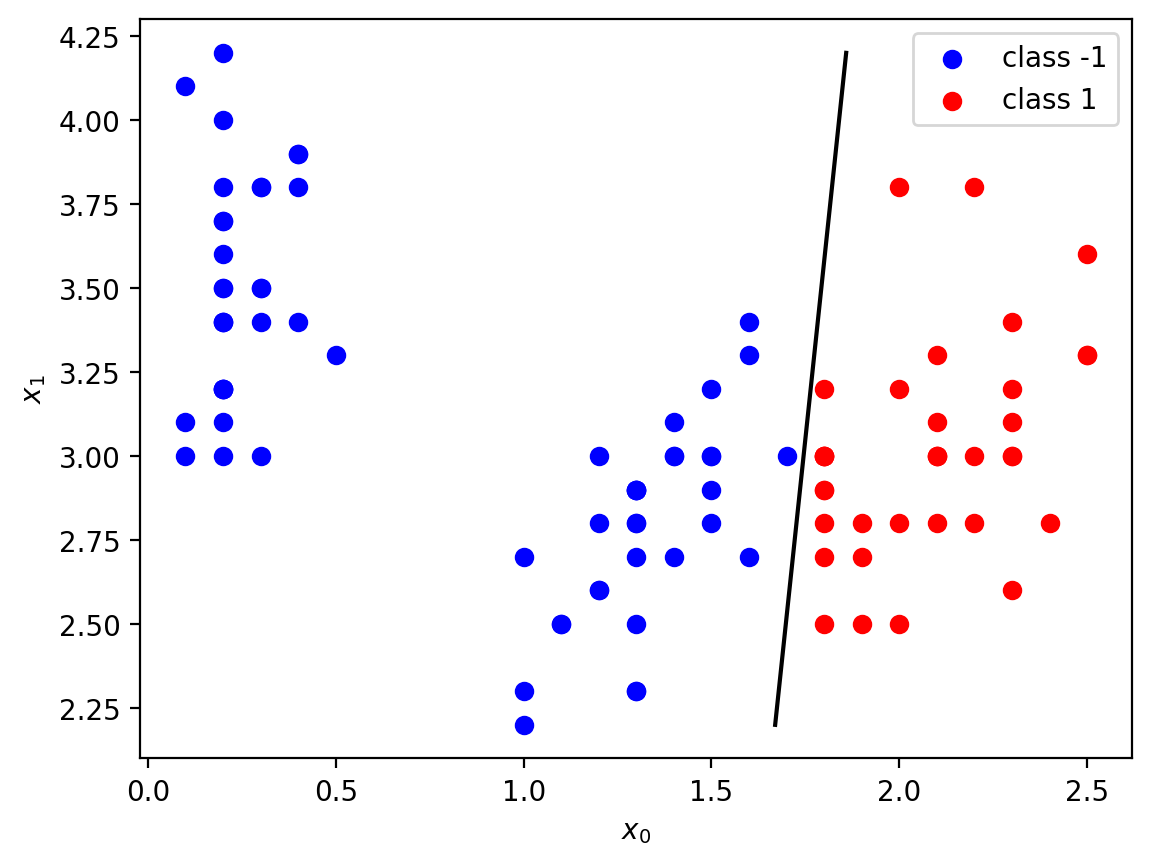

Training error: 0.0


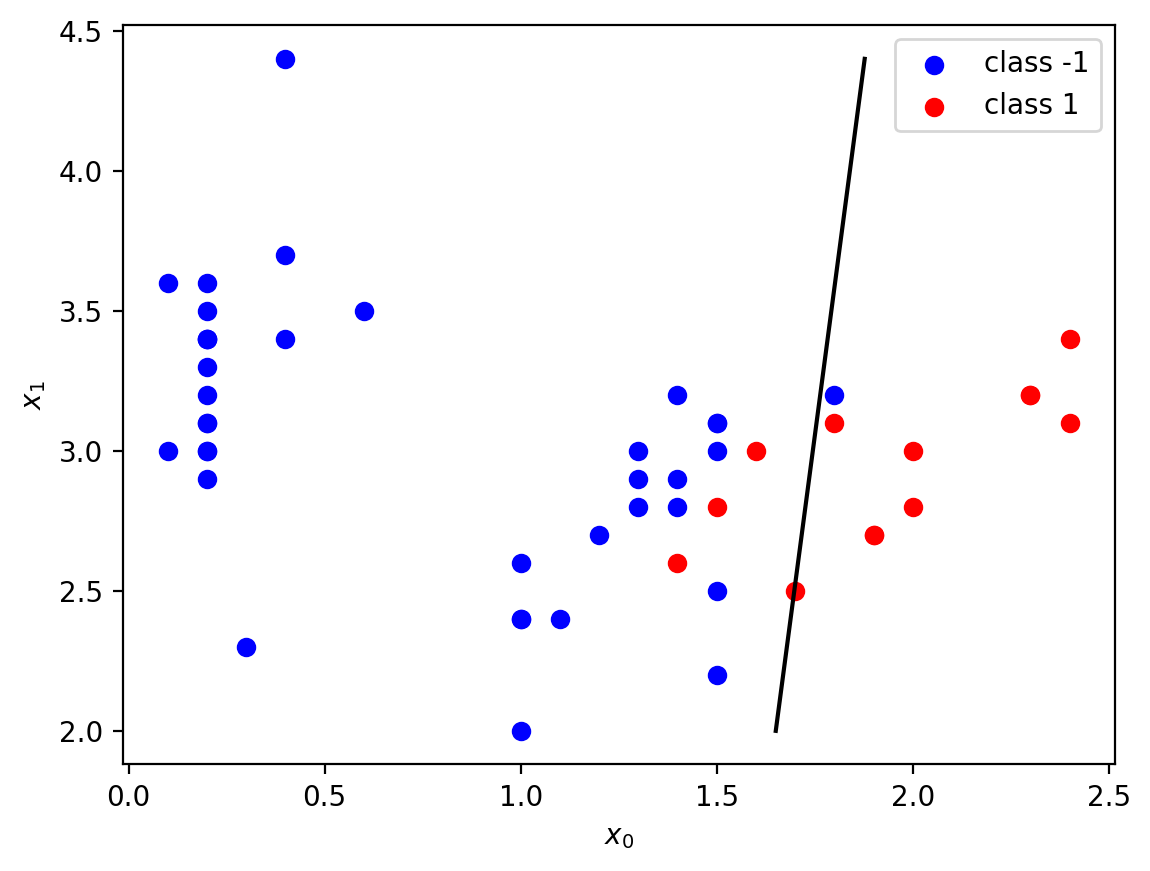

Test error: 0.08


In [15]:
# Show decision boundary, training error and test error.
print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(W[0],W[1],b))
vis(X_train, Y_train, W, b) 
print('Training error: {}'.format(calc_error(X_train, Y_train, W, b)))
vis(X_test, Y_test, W, b)  
print('Test error: {}'.format(calc_error(X_test, Y_test, W, b)))

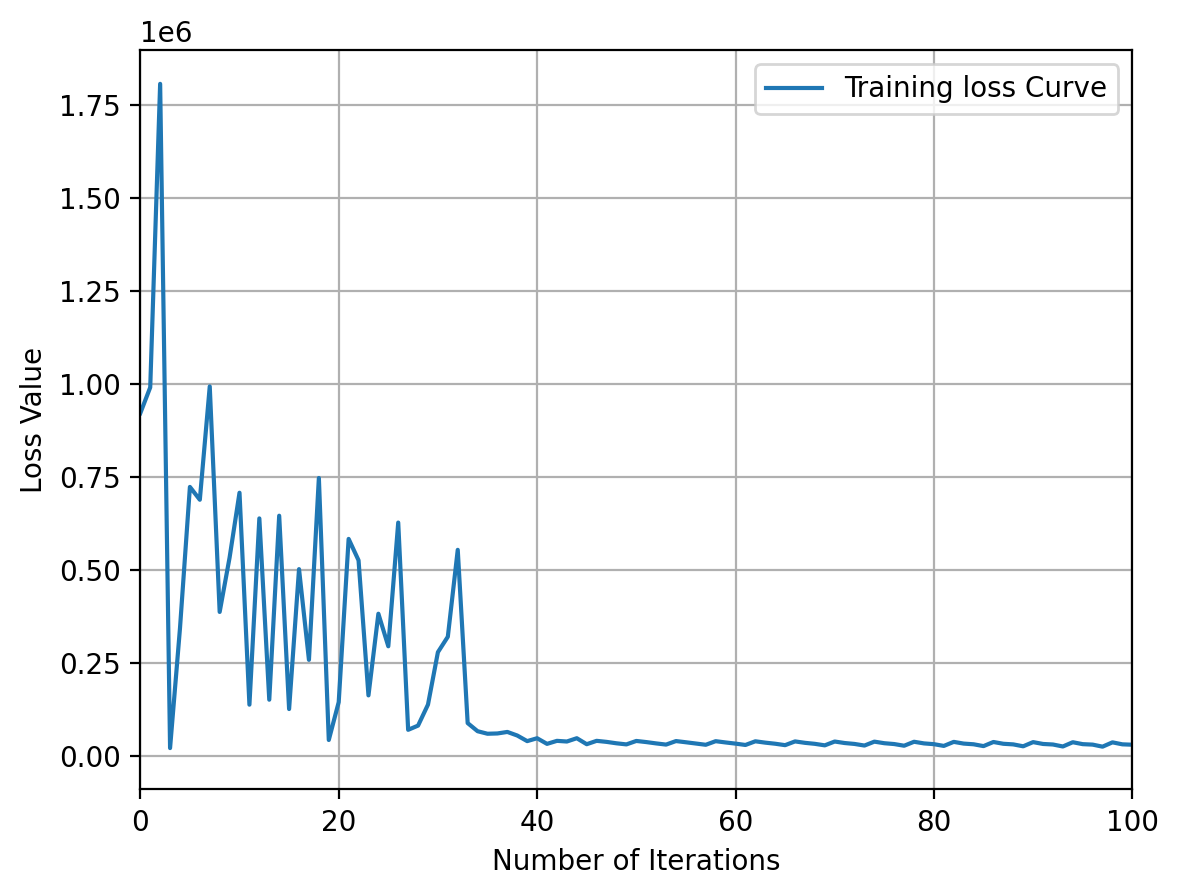

In [16]:
# Plot training loss curve.
plt.figure()
plt.plot(range(len(losses)), losses, label = "Training loss Curve")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss Value")
plt.xlim(0, 100)
plt.grid(True)
plt.legend()
plt.show()

# Question 2 SVM with Scikit-Learn

In [17]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import accuracy_score

### Load the modified Iris dataset

In [18]:
# Iris dataset.
iris = datasets.load_iris()     # Load Iris dataset.

X = iris.data                   # The shape of X is (150, 4), which means
                                # there are 150 data points, each data point
                                # has 4 features.

Y = (iris.target > 1.5).reshape(-1,1).astype(float) # The shape of Y is (150, 1), which means
                                # there are 150 data points, each data point
                                # has 1 target value.
Y[Y==0] = -1

X_and_Y = np.hstack((X, Y))     # Stack them together for shuffling.
np.random.seed(1)               # Set the random seed.
np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array

print(X.shape)
print(Y.shape)
print(X_and_Y[0])    

(150, 4)
(150, 1)
[ 5.8  4.   1.2  0.2 -1. ]


In [19]:
# Divide the data points into training set and test set.
X_shuffled = X_and_Y[:,:4]
Y_shuffled = X_and_Y[:,4]


X_train = X_shuffled[:100][:,[3,1]] # Shape: (100,2)
X_train = np.delete(X_train, 42, axis=0) # Remove a point for separability.
Y_train = Y_shuffled[:100]          # Shape: (100,)
Y_train = np.delete(Y_train, 42, axis=0) # Remove a point for separability.
X_test = X_shuffled[100:][:,[3,1]]  # Shape: (50,2)
Y_test = Y_shuffled[100:]           # Shape: (50,)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(99, 2)
(99,)
(50, 2)
(50,)


In [20]:
def vis(X, Y, W=None, b=None):
    indices_neg1 = (Y == -1).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1],
                c='blue', label='class -1')
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1],
                c='red', label='class 1')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

    if W is not None:
        # w0x0+w1x1+b=0 => x1=-w0x0/w1-b/w1
        w0 = W[0]
        w1 = W[1]
        temp = -w1*np.array([X[:,1].min(), X[:,1].max()])/w0-b/w0
        x0_min = max(temp.min(), X[:,0].min())
        x0_max = min(temp.max(), X[:,1].max())
        x0 = np.linspace(x0_min,x0_max,100)
        x1 = -w0*x0/w1-b/w1
        plt.plot(x0,x1,color='black')

    plt.show()

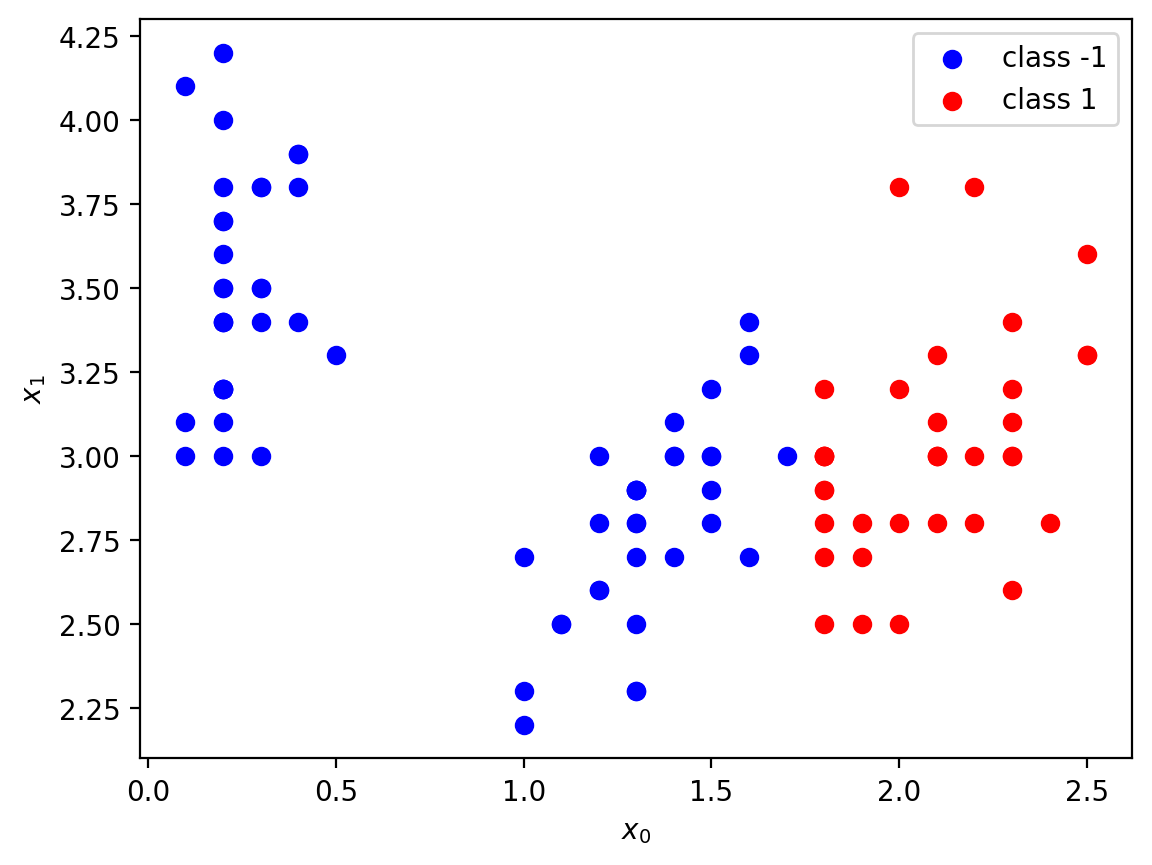

In [21]:
# Visualize training set.
vis(X_train, Y_train)

### Linear SVM Using Scikit-Learn

In [22]:
# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, classifier):

    # Hint: Use classifier.predict()
    Y_pred = classifier.predict(X)

    # Hint: Use accuracy_score().
    e = 1.0 - accuracy_score(Y, Y_pred)
    return e

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C = 0.1
Decision boundary: 1.307x0+-0.520x1+-0.397=0


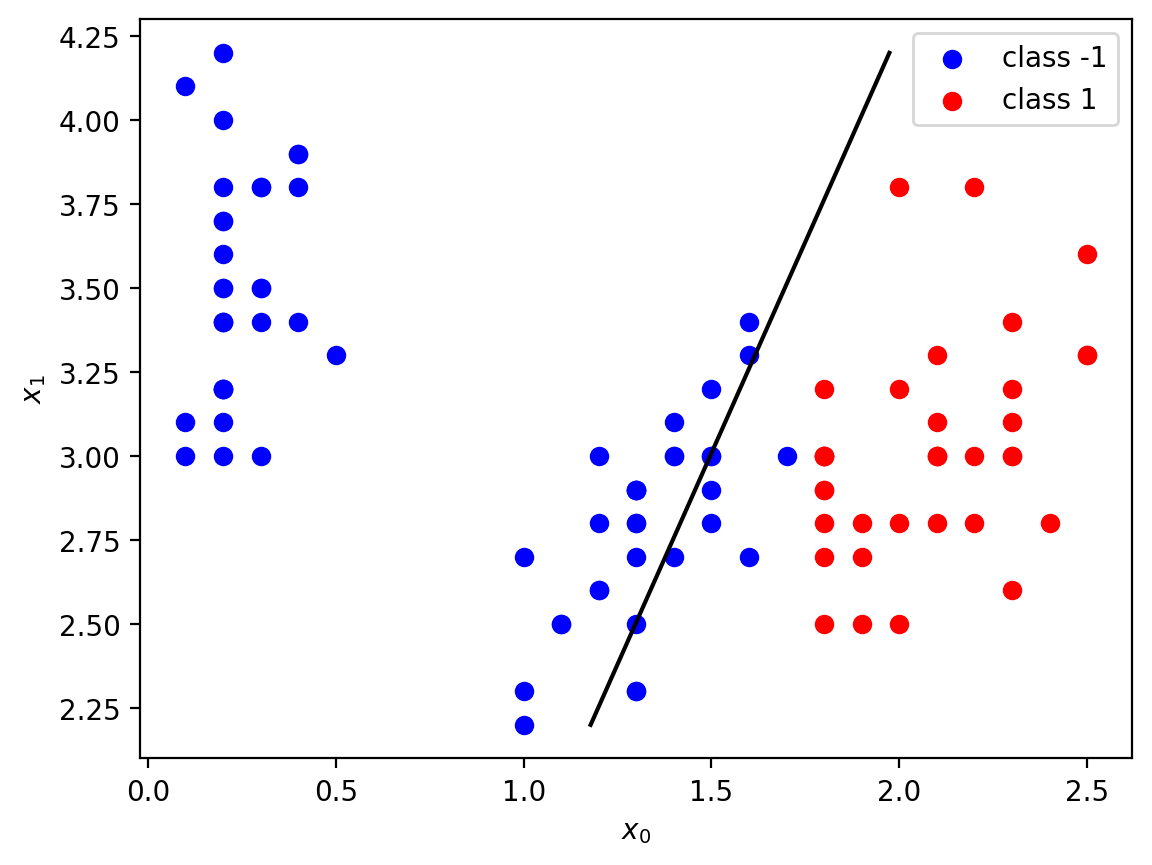

Training error: 0.101010101010101




C = 1
Decision boundary: 3.445x0+-1.386x1+-1.665=0


/opt/conda/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


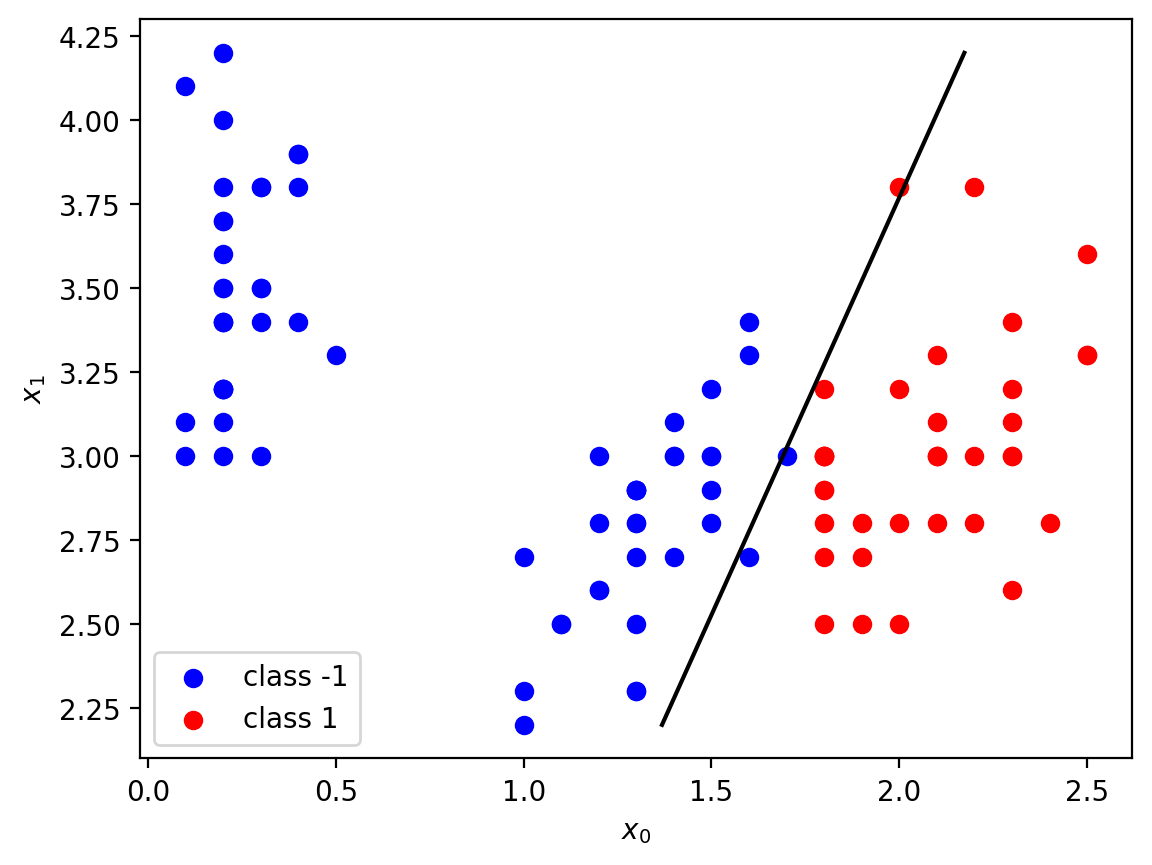

Training error: 0.030303030303030276




C = 10
Decision boundary: 6.667x0+-1.905x1+-5.286=0


/opt/conda/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


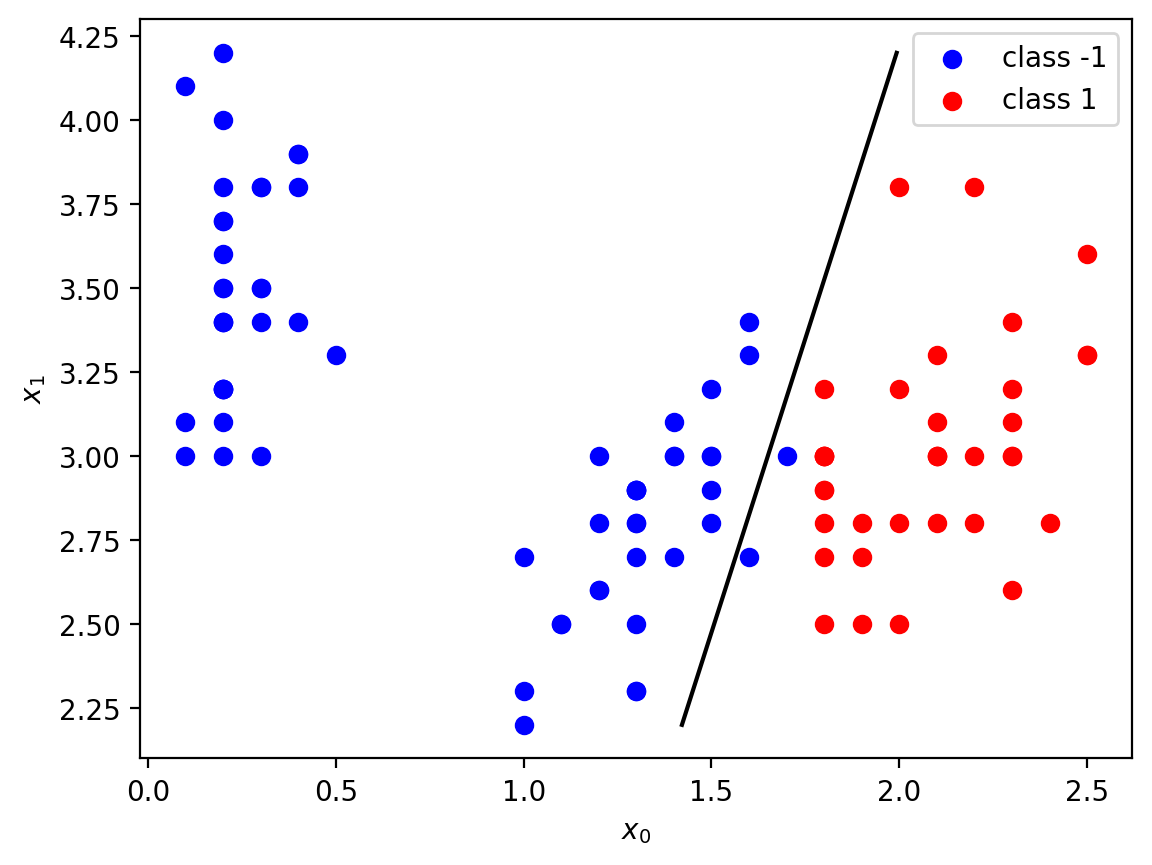

Training error: 0.02020202020202022




C = 100
Decision boundary: 9.290x0+-0.473x1+-14.305=0


/opt/conda/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


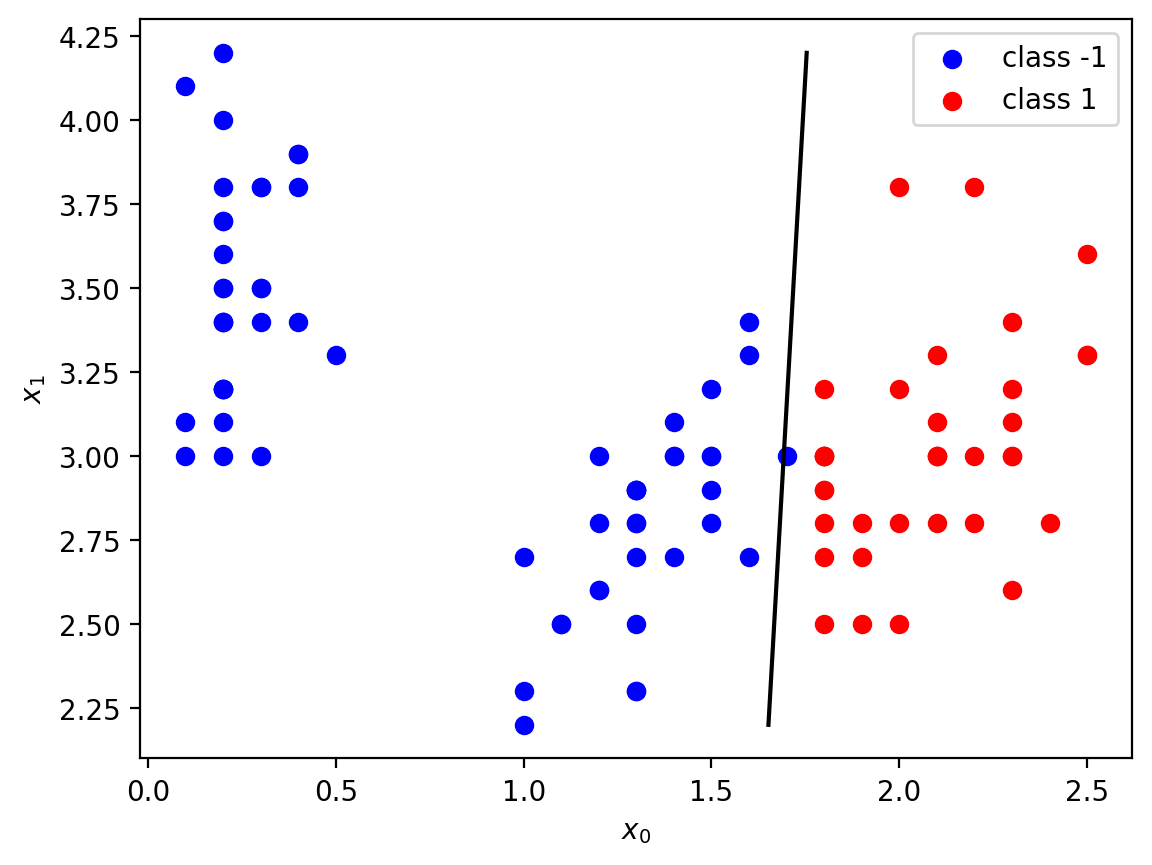

Training error: 0.010101010101010055




C = 1000
Decision boundary: 19.999x0+-0.000x1+-34.998=0


/opt/conda/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


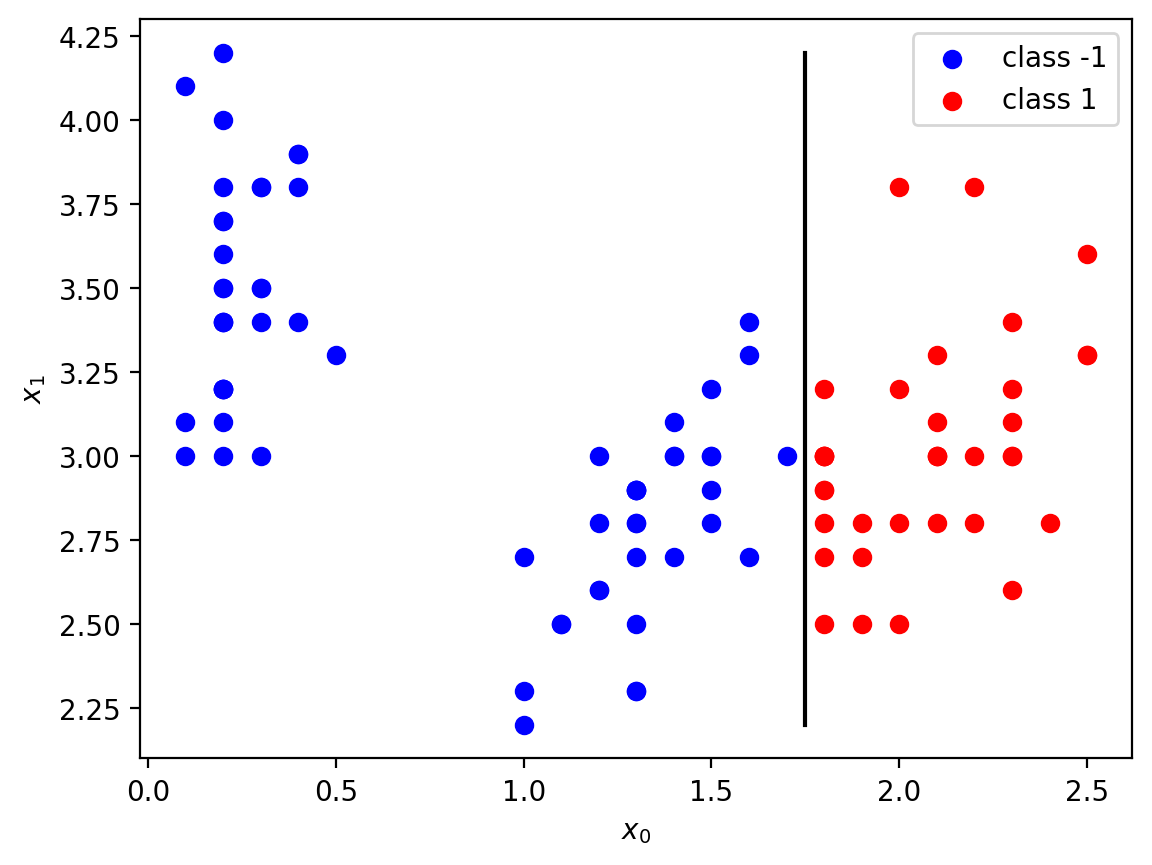

Training error: 0.0






In [25]:
C_list = [0.1, 1, 10, 100, 1000]
opt_e_training = 1.0   # Optimal training error.
opt_classifier = None  # Optimal classifier.
opt_C          = None  # Optimal C.

for C in C_list:
    classifier = svm.LinearSVC(loss = 'hinge', penalty = 'l2', C = C, max_iter = 100000)
    classifier.fit(X_train, Y_train)

    # Obtain the weights and bias from the linear SVM classifier.
    W = classifier.coef_[0]
    b = classifier.intercept_[0]

    # Show decision boundary, training error and test error.
    print('C = {}'.format(C))
    print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(W[0],W[1],b))
    vis(X_train, Y_train, W, b)
    e_training = calc_error(X_train, Y_train, classifier)
    print('Training error: {}'.format(e_training))
    print('\n\n\n')

    # Judge if it is the optimal one.
    if e_training < opt_e_training:
        opt_e_training = e_training
        opt_classifier = classifier
        opt_C = C

Best parameter C* = 1000
Decision boundary: 19.999x0+-0.000x1+-34.998=0


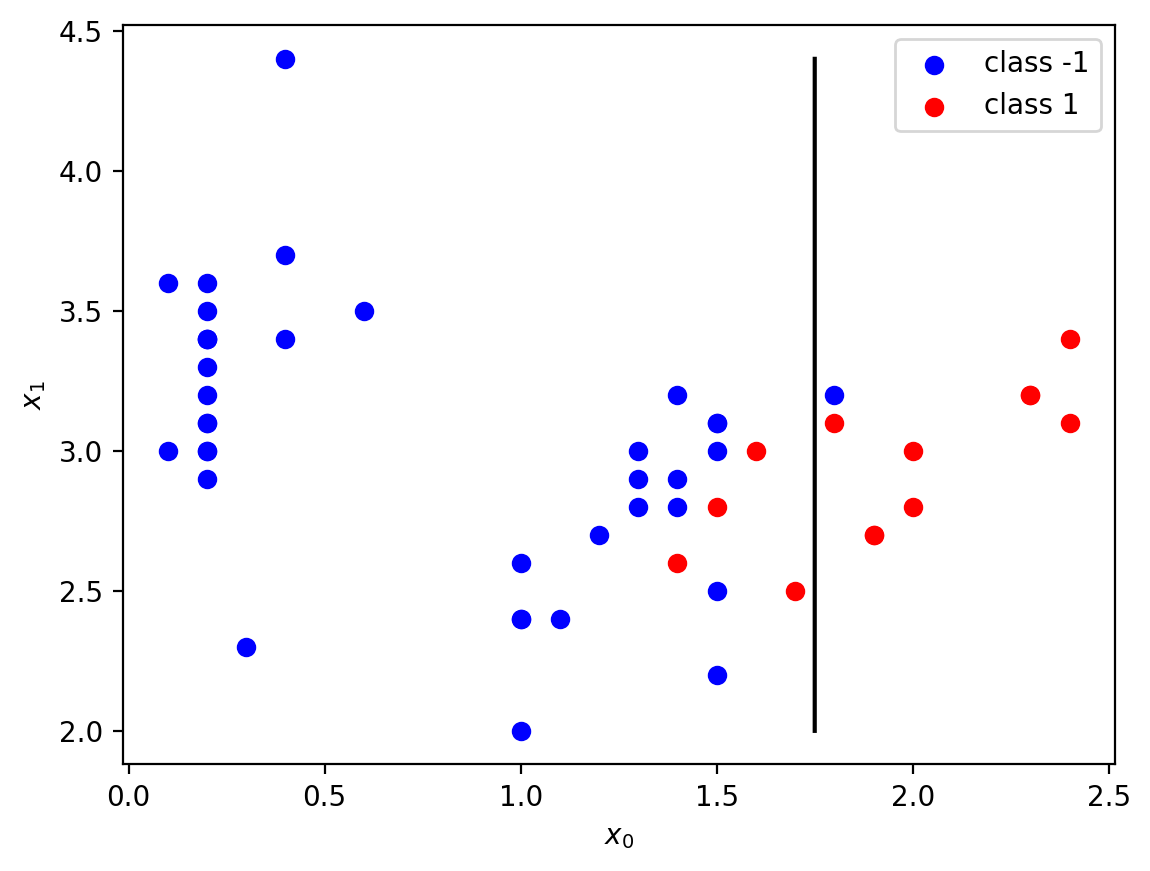

Test error: 0.09999999999999998


In [26]:
# Obtain the weights and bias from the best linear SVM classifier.
opt_W = opt_classifier.coef_[0]
opt_b = opt_classifier.intercept_[0]
print('Best parameter C* = {}'.format(opt_C))
print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(opt_W[0],opt_W[1],opt_b))
vis(X_test, Y_test, opt_W, opt_b)
print('Test error: {}'.format(calc_error(X_test, Y_test, opt_classifier)))